# AutoEncoder Apporach for Similarity Measurement

Instead of applying a similarty measure (e.g. cosine measure) directly on the personality values of the movie characters, this approach tries to do some preprocessing using AutoEncoders.

AutoEncoders are neural networks that consist of an encoder part with a descending node count in each layer and a decoder part that is set up exactly in reverse. They are trained with the same data as input and output, so no manually labled training data is required. The internal representation in the center of the network has less dimensions than the input and output layer, so training the network means it has to learn the key features of the input that are important to recreate the output.

The idea behind this approach is to learn which features are important personality features and which features are dependent on or correlating with other features.

## Imports

All required imports are listed here. The notebook works best with Anaconda and needs at least numpy, scipy, theano and keras installed.

In [17]:
# Tell matplotlib to show the results directly within the notebook instead
# of using popup windows
%matplotlib inline

# Basic keras functionality to define network models
from keras.models import Model

# Needed layer classes for "normal" autoencoders ...
from keras.layers import Input, Dense

# ... and those we need for convolutional autoencoders
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D

# To add sparsity as regularization
from keras import regularizers

from keras.optimizers import SGD

# Save keras models to json files
from keras.models import model_from_json

# Directory creation
import os

# numpy is always a good idea
import numpy as np

# cosine measure etc.
import scipy

# And finally matplotlib for drawing the images
import matplotlib.pyplot as plt

# Extended syntax for print as function
from __future__ import print_function

## Individual configuration

Please change the following variables to fit your configuration:

In [2]:
# Set it to the same directory that has been configured under autoenc.workDir in your server.user.conf:
workingDirectory = "/home/frank/watson/server/autoenc/"



#######################################################
# Create required subdirectories
def checkForDir(d):
    if not os.path.exists(d):
        os.makedirs(d)

checkForDir(workingDirectory)
checkForDir(workingDirectory+"models")
checkForDir(workingDirectory+"output")
checkForDir(workingDirectory+"tmp")


## Function definitions

Function definitions that are required for each network configuration are stored here (e.g. data loading):

### Data loading

After running `fetchData.py` in `Server/Tools/InsightsAutoEncoder` there is a `characters.vec` file in the working directory configured above. The following function loads the vectors from this file and returns them as a numpy matrix:

In [45]:
def loadCharacterVectors():
    global workingDirectory
    vecs,_ = loadVectorFile("characters.vec")
    return vecs

def loadVectorFile(filename, silent=False):
    idx2meta = {}
    data = []
    n=1
    idx = 0
    for line in open(workingDirectory+filename,"r"):
        line=line.strip()
        lineData = line.split("\t",2)
        if len(lineData)==3:
            movieId, charName, valueString = lineData
            data.append([float(f) for f in valueString.split(" ")])
            idx2meta[idx] = {'movie': movieId, 'character': charName}
            idx+=1
        else:
            if not silent:
                print("ParseError in line "+str(n))
        n+=1
    return np.matrix(data, dtype='float32'), idx2meta

A function to find a character in the meta data:

In [4]:
def getCharacterIndex(meta, movieId, character):
    for idx,val in meta.items():
        if val['movie']==movieId and character==val['character']:
            return idx
    return None

### Model saving and loading

We save our models and the trained weights in the json format. Here are some helper functions:

In [5]:
def saveJSONModel(model, filename):
    global workingDirectory
    with open(workingDirectory+filename,'w') as modelFile:
        modelFile.write(model.to_json())

def loadJSONModel(filename):
    global workingDirectory
    with open(workingDirectory+filename,'r') as modelFile:
        return model_from_json(file.read())

### Data conversion

The following function takes  an encoder and uses them to create a low-dimensional output file for the characters:

In [6]:
def applyEncoder(encoder, outputFile):
    global workingDirectory
    with open(workingDirectory+outputFile,"w") as outFile:
        for line in open(workingDirectory+"characters.vec","r"):
            line=line.strip()
            lineData = line.split("\t",2)
            if len(lineData)==3:
                movieId, charName, valueString = lineData
                encoderOut = encoder.predict(np.matrix([float(f) for f in valueString.split(" ")]))
                outFile.write(movieId+"\t"+charName+"\t")
                outFile.write(" ".join([str(encoderOut.item(n)) for n in xrange(encoderOut.shape[1])]))
                outFile.write("\n")

### Ranking

The following function uses the cosine measure to return a ordered list of (matrix index, similarity)-tupels, descending by similarity to a reference index:

In [7]:
def matrixCosine(matrix, referenceIdx):
    reference = matrix[referenceIdx]
    similarity = []
    for n in xrange(matrix.shape[0]):
        similarity.append([n, 1.0-scipy.spatial.distance.cosine(reference, matrix[n])])
    return [n for n in sorted(similarity, key=lambda v: v[1], reverse=True)]


## Input data

Now, we can load the input data. At the moment, the network does not use a split as testing data as we know all vectors that may occur (this may change when we allow the users to supply individual texts).

In [8]:
# Read all the data
dataX = loadCharacterVectors()

# Some errors may occur due to character names containing a line break.
# This has to be fixed in either the MetaDataCrawler (clean solution) or in fetchData.py (workaround-style)

ParseError in line 557
ParseError in line 558
ParseError in line 576
ParseError in line 577
ParseError in line 979
ParseError in line 980
ParseError in line 1849
ParseError in line 1850
ParseError in line 2286
ParseError in line 2287
ParseError in line 2974
ParseError in line 2975
ParseError in line 3646
ParseError in line 3647
ParseError in line 3745
ParseError in line 3746
ParseError in line 3786
ParseError in line 3787
ParseError in line 3873
ParseError in line 3874
ParseError in line 4458
ParseError in line 4459
ParseError in line 4851
ParseError in line 4852


## Models

Here are the models that have been created. Learned data can be saved to and load from json files, so for each model there are three code snippets: One creates the modle structure, one saves the learned data and one restores it.



### "Default" AutoEncoder

This is a simple, one-layered AutoEncoder, mapping the input to an internal representation of five values.

#### Model Creation Code

_(Run this to create a new model in memory)_

In [23]:
# Here we define the size of our internal representation. For a first try, we use the value 5:
encodingDim = 5

# We need a placeholder value for the input data. To create one, we need to know the dimension of the input.
# As we already did load the test data, we can derive the value from there, making the code more flexible:
inputDimension = dataX.shape[1]

# With this dimension, we are able to create the actual placeholder object.
# At the moment, inputDimension is 35, so our model takes 35-component-vectors as input.
inputData = Input(shape=(inputDimension,))

# "encoded" is the encoded representation of the input
# This layer takes the input placeholder als input and maps it to
# our encoded data in the 5-dimensional hidden layer
# The activation function we choose is ReLU
encoded = Dense(encodingDim, activation='relu')(inputData)

# "decoded" is the lossy reconstruction of the input
# In the same way we shrinked the input vector with a Dense layer, we can make it grow again:
decoded = Dense(inputDimension, activation='tanh')(encoded)
# (Note that the activation function here is tanh, because the personality values aren't normalized
# by now. Using "sigmoid" would restrict the output to positive values, so that the network will
# never be able to learn something helpful)

sgd = SGD(lr=0.0001)

# That's basically it. We have our encoded-Function, the decoded-Function and with both of them, we can
# build up and compile the completed model of the first AutoEncoder:
defaultAutoencoder = Model(input=inputData, output=decoded)
defaultAutoencoder.compile(optimizer=sgd, loss='mean_squared_error')


# Finally, we do the same for the encoder only. Using the same layers as for the AutoEncoder, we have
# the advantage of weight-sharing. So training the AutoEncoder is also "training" the encoder itself:
defaultEncoder = Model(input=inputData, output=encoded)
# To be able to use it individually, we need to compile it:
defaultEncoder.compile(optimizer=sgd, loss='mean_squared_error')

#### Saving Code

_(Run this to save the model to the json file)_

In [24]:
# Save the learned data to models/defaultAutoEnc-5.json
saveJSONModel(defaultAutoencoder, "models/defaultAutoEnc-5.json")

#### Loading Code

_(Run this to load a model from json file)_

In [ ]:
# Load the model from JSON
defaultAutoencoder = loadJSONModel("models/defaultAutoEnc-5.json")

# To have a weight-sharing Encoder, we need to get it out of the model again:

# TODO

#### Training Code

In [40]:
defaultAutoencoder.fit(dataX, dataX, # Same data for input and output
    nb_epoch=10000,                  # Train for 50 epochs
    batch_size=128,                  # 128 characters batch size
    shuffle=True,                    # Shuffle input data
    verbose = 2)                     # Required to run in jupyter notebook
print("Training done")

Epoch 1/5000
0s - loss: 5.6836e-04
Epoch 2/5000
0s - loss: 5.6820e-04
Epoch 3/5000
0s - loss: 5.6805e-04
Epoch 4/5000
0s - loss: 5.6789e-04
Epoch 5/5000
0s - loss: 5.6774e-04
Epoch 6/5000
0s - loss: 5.6758e-04
Epoch 7/5000
0s - loss: 5.6743e-04
Epoch 8/5000
0s - loss: 5.6727e-04
Epoch 9/5000
0s - loss: 5.6712e-04
Epoch 10/5000
0s - loss: 5.6696e-04
Epoch 11/5000
0s - loss: 5.6681e-04
Epoch 12/5000
0s - loss: 5.6665e-04
Epoch 13/5000
0s - loss: 5.6650e-04
Epoch 14/5000
0s - loss: 5.6634e-04
Epoch 15/5000
0s - loss: 5.6619e-04
Epoch 16/5000
0s - loss: 5.6603e-04
Epoch 17/5000
0s - loss: 5.6588e-04
Epoch 18/5000
0s - loss: 5.6572e-04
Epoch 19/5000
0s - loss: 5.6557e-04
Epoch 20/5000
0s - loss: 5.6541e-04
Epoch 21/5000
0s - loss: 5.6526e-04
Epoch 22/5000
0s - loss: 5.6511e-04
Epoch 23/5000
0s - loss: 5.6495e-04
Epoch 24/5000
0s - loss: 5.6480e-04
Epoch 25/5000
0s - loss: 5.6464e-04
Epoch 26/5000
0s - loss: 5.6449e-04
Epoch 27/5000
0s - loss: 5.6434e-04
Epoch 28/5000
0s - loss: 5.6418e-04
E

#### Simple test run:

To see if the AutoEncoder works, we compare the input and output for the first five characters in a polar coordinate system:

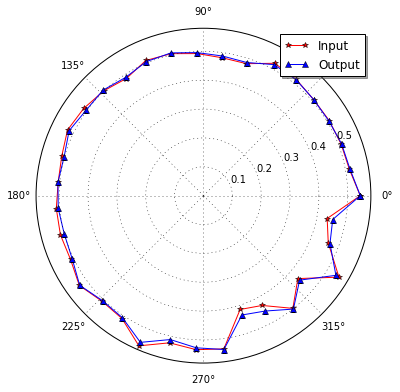

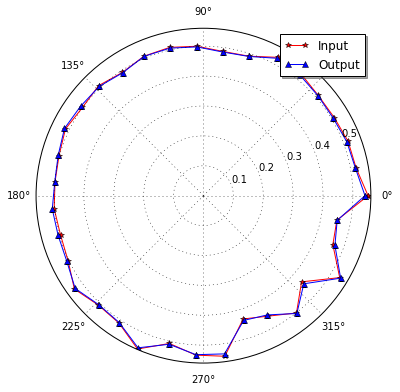

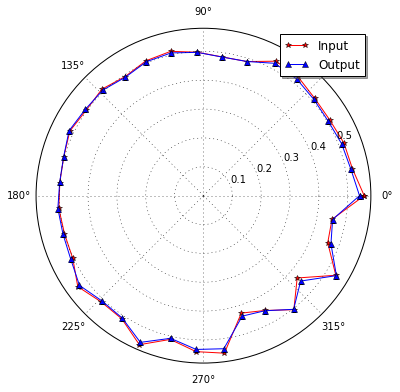

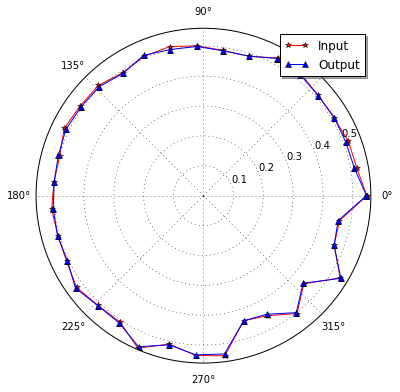

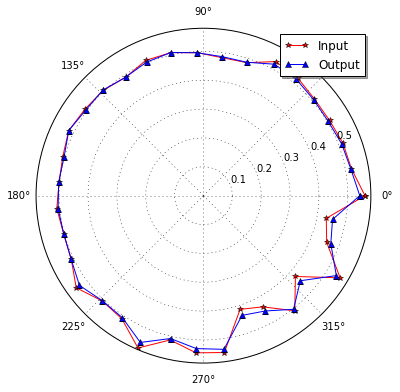

In [41]:
for i in xrange(5):
    testInput = dataX[i*100]
    testOutput = defaultAutoencoder.predict(testInput)
    
    fig = plt.figure()
    fig.set_size_inches(6,6)
    ax = fig.add_subplot(111, projection='polar')

    ax.set_rmax(1.0)
    
    angles = [float(f)*6.28/35.0 for f in xrange(35)]
    angles += [angles[0]]
    
    ax.plot(angles,[(1.0+testInput.item(n%35))/2.0  for n in xrange(36)],"*r-",label="Input")
    ax.plot(angles,[(1.0+testOutput.item(n%35))/2.0 for n in xrange(36)],"^b-",label="Output")
    
    ax.legend(loc='upper right', shadow=True)
    plt.show()   

Obviously, the five values are enough to recreate most of the personality values pretty well, without any optimization of the model.

Now, we convert the full-dimensional input file to a low-dimensional one using our encoder:

In [42]:
applyEncoder(defaultEncoder, "output/defaultEncoder.lowdim.vec")

And then, load this file and test it:

In [ ]:
# Load the data from the encoder
defaultEncEncodedData, defaultEncMetaData = loadVectorFile("output/defaultEncoder.lowdim.vec")

# Load the original data
origEncodedData, origMetaData = loadVectorFile("characters.vec", silent=True)

In [66]:
targetMovies = ["Lord of the Rings: Fellowship of the Ring, The",
               "Lord of the Rings: Return of the King",
               "Lord of the Rings: The Two Towers"]
# Reference Character Movie Name
# Reference Character Character Name
# Vektor data from loadVectorFile
# Meta data from loadVectorFile
# Print first n results
# List of movies that the characters should be from (referenceMovie is always included, None=All movies)
def printEncoderResults(referenceMovie, referenceChar, vectors, metaData, n=10, movies = None):
    print(referenceChar+" ("+referenceMovie+")")
    print(65*"=")
    cId = getCharacterIndex(metaData, referenceMovie, referenceChar)
    if cId is not None:
        cRes = matrixCosine(vectors, cId)
        
        # Show for all movies
        if movies is None:
            for i in xrange(n):
                res = metaData[cRes[i][0]]
                print(res['character']+" ("+res['movie']+")")
                print("\tSimilarity: "+str(cRes[i][1]))
        # Show for movie list only
        else:
            movies+=[referenceMovie]
            count=0
            for i in xrange(len(cRes)):
                res = metaData[cRes[i][0]]
                if res['movie'] in movies:
                    count+=1
                    print(res['character']+" ("+res['movie']+")")
                    print("\tSimilarity: "+str(cRes[i][1]))
                if count>=n:
                    break
    else:
        print("Reference character/movie not found")

printEncoderResults("Lord of the Rings: Fellowship of the Ring, The", "Theoden", defaultEncEncodedData, defaultEncMetaData, n=25, movies=targetMovies)
print()
printEncoderResults("Lord of the Rings: Fellowship of the Ring, The", "Theoden", origEncodedData, origMetaData, n=25, movies=targetMovies)

Theoden (Lord of the Rings: Fellowship of the Ring, The)
Reference character/movie not found

Theoden (Lord of the Rings: Fellowship of the Ring, The)
Reference character/movie not found
